# Breast cancer detection project

# I. Gathering Data

In [ ]:
# IMPORTS
import kagglehub
import numpy as np
import tensorflow as tf
import random
import glob
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

print("Path to dataset files:", path)

100%|██████████| 3.10G/3.10G [00:29<00:00, 112MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1


In [ ]:
import os

dataPath = os.path.join(os.path.expanduser("~"), ".cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1")
print(dataPath)

/root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1


## II. Data Handling

In [ ]:
# Get all the paths to the images
# -> glob allows for pattern matching to get all the photo paths
idc_neg = glob.glob(dataPath +'/*/0/*.png', recursive = True)
idc_pos = glob.glob(dataPath +'/*/1/*.png', recursive = True)

# Total : 277,524 patches of size 50 x 50 (198,738 IDC negative and 78,786 IDC positive)
print("Number of IDC negative patches: ", len(idc_neg))
print("Number of IDC positive patches: ", len(idc_pos))
print("Total number of patches: ", len(idc_neg) + len(idc_pos))

Number of IDC negative patches:  198738
Number of IDC positive patches:  78786
Total number of patches:  277524


In [ ]:
# Function to convert the image to a tensor
import cv2

def image_to_numpy(image_path, target_size=(50, 50)):
    # Load the image in BGR format
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Image not found or unable to load: {image_path}")

    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image to the target size
    img_resized = cv2.resize(img_rgb, target_size, interpolation=cv2.INTER_AREA)

    return img_resized / 255

# Example usage
example_image_path = '/8863/0/8863_idx5_x51_y1251_class0.png'
example_tensor = image_to_numpy(dataPath + example_image_path)
print("Shape of the tensor: ", example_tensor.shape)

Shape of the tensor:  (50, 50, 3)


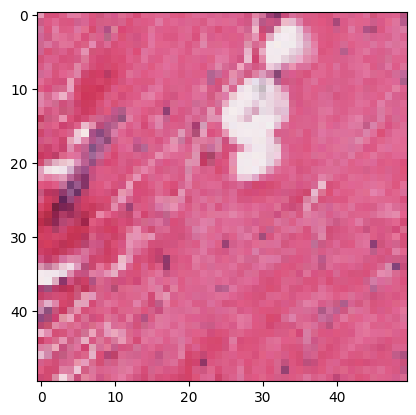

In [ ]:
# Function to plot the image
def plot_image(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)

# Example usage
plot_image(idc_neg[0])



## III. Data analysis & Data Preparation

In [ ]:
# Get 12000 random idc negative image and convert to numpy arrays
idc_neg_numpy = []

for i in random.sample(range(0, len(idc_neg)), 12000):
    idc_neg_numpy.append(image_to_numpy(idc_neg[i]))

# Get 12000 random idc positive image and convert to numpy arrays
idc_pos_numpy = []

for i in random.sample(range(0, len(idc_pos)), 12000):
    idc_pos_numpy.append(image_to_numpy(idc_pos[i]))

# We combine the negative and positive data and create a y lable numpy array.
X = np.array(idc_neg_numpy + idc_pos_numpy)
y = np.array([0] * len(idc_neg_numpy) + [1] * len(idc_pos_numpy))
print(X.shape)
print(y.shape)
print()

# get X train, X test, y train, y test with sklearn.model_selection's train_test_split
# test split is 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(24000, 50, 50, 3)
(24000,)

(19200, 50, 50, 3)
(19200,)
(4800, 50, 50, 3)
(4800,)


## IV. Model Building

#### Model 1

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
#Initialize the Sequential model:
model1 = Sequential()

model1.add(Conv2D(32, (5, 5), strides=(1, 1), input_shape=(50, 50, 3), activation='relu', data_format="channels_last"))
model1.add(Conv2D(64, (5, 5), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model1.add(Flatten())
model1.add(Dense(1, activation='sigmoid'))

#Compiling the model, loss: categorical crossentropy, it is the most popular for these kind of problems,
#optimizer: adam, a faster variant of the stochastic gradient method
#metrics: accuracy (We want to know the accuracy after each epoch.)
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#We want to stop the training process, if the loss on the validation set did not improve since 10 epochs.
early_stopping=EarlyStopping(patience=10, verbose=1)

#We do not want to store the weights of the model after the last epoch, we want the weights of the best model!
#We will store those weights in a file weights.hdf5
checkpointer=ModelCheckpoint(filepath='weights1.keras', save_best_only=True, verbose=1)

#Fit with 10 epochs of 128 records each (batch_size) and 0.2 validation split
#Specify which callbacks or 'plugins' to use.
network_history = model1.fit(X_train, y_train, batch_size=128,
                            epochs=10, verbose=1, validation_split=0.2,
                  callbacks=[checkpointer, early_stopping])

Epoch 1/10
118/120 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5871 - loss: 0.6831
Epoch 1: val_loss improved from inf to 0.49170, saving model to weights1.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5892 - loss: 0.6811 - val_accuracy: 0.7898 - val_loss: 0.4917
Epoch 2/10
118/120 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7855 - loss: 0.4922
Epoch 2: val_loss improved from 0.49170 to 0.48806, saving model to weights1.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7852 - loss: 0.4925 - val_accuracy: 0.7990 - val_loss: 0.4881
Epoch 3/10
118/120 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7831 - loss: 0.4833
Epoch 3: val_loss improved from 0.48806 to 0.48614, saving model to weights1.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7831 - loss: 0.4833 - val_accuracy: 0.7685 - val_loss: 0.4861
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7512 - loss: 0.5504
Epoch 4: val_loss did not improve from 0.48614
120/12

In [ ]:
from keras.models import load_model
model1 = load_model("weights1.keras")
test_err = model1.evaluate(X_test,y_test)
print("Loss on test set:", test_err[0], "Accuracy on test set:", test_err[1])

150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8001 - loss: 0.4494
Loss on test set: 0.45716461539268494 Accuracy on test set: 0.7945833206176758


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix

y_pred = model1.predict(X_test)
print(y_pred[0])
y_pred = model1.predict(X_test) > 0.5
y_pred = y_pred.astype(int)
print(y_pred[0])
y_true = y_test
print(y_true[0])

print("Test accuracy: %g" %(accuracy_score(y_true, y_pred)))
print("Precision", precision_score(y_true, y_pred, average="macro")) #one vs rest averages or global
print("Recall", recall_score(y_true, y_pred, average="macro")) #macro calculates the average of the recall for each class
print("f1_score", f1_score(y_true, y_pred, average="macro")) #macro is good for balanced data set, micro is good for imbalanced
print("\n Confusion matrix ")
conf=confusion_matrix(y_true, y_pred)
print(conf)

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[0.28209376]
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[0]
0
Test accuracy: 0.794583
Precision 0.7946065601520893
Recall 0.7945991948845114
f1_score 0.7945830123692902

 Confusion matrix 
[[1910  481]
 [ 505 1904]]


### Model 2

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

model2 = Sequential()

# First Conv Block
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

# Second Conv Block
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(Dropout(0.2))

# Third Conv Block
model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(Dropout(0.2))

model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(Dropout(0.2))

model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

# Global Average Pooling + Fully Connected
model2.add(GlobalAveragePooling2D())
model2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# Callbacks
early_stopping = EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint(filepath='weights2.keras', save_best_only=True, verbose=1)

# Fit the model
network_history = model2.fit(
    X_train, y_train,
    batch_size=128, epochs=40, verbose=1, validation_split=0.2,
    callbacks=[checkpointer, early_stopping]
)

# Load the best model and evaluate
from keras.models import load_model
model2 = load_model("weights2.keras")
test_err = model2.evaluate(X_test, y_test)
print("Loss on test set:", test_err[0], "Accuracy on test set:", test_err[1])

# Metrics Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred = model2.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
y_true = y_test

print("Test accuracy: %g" % (accuracy_score(y_true, y_pred)))
print("Precision:", precision_score(y_true, y_pred, average="macro"))
print("Recall:", recall_score(y_true, y_pred, average="macro"))
print("f1_score:", f1_score(y_true, y_pred, average="macro"))

print("\nConfusion matrix:")
conf = confusion_matrix(y_true, y_pred)
print(conf)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - Precision: 0.7457 - Recall: 0.7464 - accuracy: 0.7449 - loss: 1.6816
Epoch 1: val_loss improved from inf to 1.48760, saving model to weights2.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - Precision: 0.7461 - Recall: 0.7468 - accuracy: 0.7454 - loss: 1.6775 - val_Precision: 0.5076 - val_Recall: 1.0000 - val_accuracy: 0.5076 - val_loss: 1.4876
Epoch 2/10
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - Precision: 0.7990 - Recall: 0.7855 - accuracy: 0.7932 - loss: 0.9673
Epoch 2: val_loss improved from 1.48760 to 1.24961, saving model to weights2.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - Precision: 0.7991 - Recall: 0.7856 - accuracy: 0.7933 - loss: 0.9658 - val_Precision: 0.5076 - val_Recall: 1.0000 - val_accuracy: 0.5076 - val_loss: 1.2496
Epoch 3/10
117/120 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - Precision: 0.8093 - Recall: 0.7985 - accuracy: 0.8044 - loss: 0.6878
Epoch 3: val_loss improved from 1.24961 to 1.03327, saving model 